# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat,count, desc, explode, lit, min, max, split, stddev, udf, when, isnan, from_unixtime,sqrt
from pyspark.sql.types import IntegerType, LongType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, RegexTokenizer, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import re

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify_mini") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
log = spark.read.json("mini_sparkify_event_data.json")

### Removing userId's with ''

In [4]:
log_cleaned = log.where(log.userId != '')

**Changing gender to numeric values; 1 for female, 0 for male**.

In [5]:
log_cleaned = log_cleaned.replace(['F','M'],['1','0'],'gender')
log_cleaned = log_cleaned.withColumn("gender", log_cleaned["gender"].cast(IntegerType()))

**Changing level to numeric values; 1 for paid, 0 for free.**

In [6]:
log_cleaned = log_cleaned.replace(["free", "paid"], ["0", "1"], "level")
log_cleaned = log_cleaned.withColumn("level", log_cleaned["level"].cast(IntegerType()))

### Getting time right

In [7]:
timing = udf(lambda x: x//1000, IntegerType())
log_cleaned = log_cleaned.withColumn("adj_ts", from_unixtime(timing('ts')))
log_cleaned = log_cleaned.withColumn("adj_reg", from_unixtime(timing('registration')))

**Selecting only relevant features**

In [8]:
log_cleaned = log_cleaned.select('userId','artist','auth','gender','itemInSession','length','level','location','method','page',
                                'adj_reg','sessionId','song','status','adj_ts','userAgent')

### Defining Churn

In [9]:
log_cleaned.createOrReplaceTempView("log_table")

In [10]:
churned_users = spark.sql('''
    SELECT 
        DISTINCT userId, 
        1 as label 
    FROM
        log_table 
    WHERE page = 'Cancellation Confirmation'
''')

In [11]:
didnt_churn = spark.sql('''
    SELECT
        DISTINCT userId, 
        0 as label 
    FROM 
        log_table
    WHERE userId NOT IN (
                        SELECT 
                            DISTINCT userId 
                        FROM 
                            log_table 
                        WHERE page = 'Cancellation Confirmation'
                        )
''')

In [12]:
comb_churn = didnt_churn.union(churned_users)

In [13]:
log_cleaned.createOrReplaceTempView("log_table")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### 1. Gender of user

In [14]:
user_gender = spark.sql('''
    SELECT
        DISTINCT userId,
        gender 
    FROM
        log_table
''')

### 2. Level of user

Since the users might have 1 out of 2 different levels depending on the time, I will take the maximum levelthe user has ever had.

In [15]:
user_level = spark.sql('''
    SELECT
        userId,
        MAX(level) AS level
    FROM
        log_table
    GROUP BY userId
''')

### 3. Has the user submitted downgrade? 

In [16]:
downgraded = spark.sql('''
    SELECT
        userId,
        COUNT(page) as downgraded
    FROM
        log_table
    WHERE page = 'Submit Downgrade'
    GROUP BY userID
''')

In [17]:
didnt_downgrade = spark.sql('''
    SELECT
        DISTINCT userId, 
        0 as downgraded 
    FROM 
        log_table
    WHERE userId NOT IN (
                        SELECT 
                            DISTINCT userId 
                        FROM 
                            log_table 
                        WHERE page = 'Submit Downgrade'
                        )
''')

In [18]:
num_downgrade = didnt_downgrade.union(downgraded)

### 4. Number of days as an user 

In [19]:
num_days = spark.sql('''
    SELECT
        userId,
        DATEDIFF(MAX(adj_ts),adj_reg) AS num_days
    FROM
        log_table
    GROUP BY userId, adj_reg
    ORDER BY num_days DESC
''')

### 5. Number of errors occured per days as an user

In [20]:
num_errors = spark.sql('''
    SELECT
        userId,
        COUNT(page) / DATEDIFF(MAX(adj_ts),adj_reg) as num_errors
    FROM
        log_table
    WHERE page = 'Error'
    GROUP BY userID, adj_reg
''')

### 6. Number of help events per days as an user

In [21]:
num_helps = spark.sql('''
    SELECT
        userId,
        COUNT(page) / DATEDIFF(MAX(adj_ts),adj_reg) as num_helps
    FROM
        log_table
    WHERE page = 'Help'
    GROUP BY userID, adj_reg
''')

### 7. Number of Roll Adverts per days as an user

In [22]:
num_rolladvert = spark.sql('''
    SELECT
        userId,
        COUNT(page) / DATEDIFF(MAX(adj_ts),adj_reg) as num_rolladvert
    FROM
        log_table
    WHERE page = 'Roll Advert'
    GROUP BY userID, adj_reg
''')

### 8. Number of Save Settings per days as an user

In [23]:
num_savesettings = spark.sql('''
    SELECT
        userId,
        COUNT(page) / DATEDIFF(MAX(adj_ts),adj_reg) as num_savesettings
    FROM
        log_table
    WHERE page = 'Save Settings'
    GROUP BY userID, adj_reg
''')

### 9. Number of Thumbs Down per days as an user

In [24]:
num_thumbsdown = spark.sql('''
    SELECT
        userId,
        COUNT(page) / DATEDIFF(MAX(adj_ts),adj_reg) as num_thumbsdown
    FROM
        log_table
    WHERE page = 'Thumbs Down'
    GROUP BY userID, adj_reg
''')

### 10. Number of Thumbs Up per days as an user

In [25]:
num_thumbsup = spark.sql('''
    SELECT
        userId,
        COUNT(page) / DATEDIFF(MAX(adj_ts),adj_reg) as num_thumbsup
    FROM
        log_table
    WHERE page = 'Thumbs Up'
    GROUP BY userID, adj_reg
''')

### 11. Number of Submit Upgrade

In [26]:
upgraded = spark.sql('''
    SELECT
        userId,
        COUNT(page) as upgraded
    FROM
        log_table
    WHERE page = 'Submit Upgrade'
    GROUP BY userID
''')

In [27]:
didnt_upgrade = spark.sql('''
    SELECT
        DISTINCT userId, 
        0 as upgraded 
    FROM 
        log_table
    WHERE userId NOT IN (
                        SELECT 
                            DISTINCT userId 
                        FROM 
                            log_table 
                        WHERE page = 'Submit Upgrade'
                        )
''')

In [28]:
num_upgrade = didnt_upgrade.union(upgraded)

### Joining data 

In [29]:
all_data = comb_churn \
    .join(user_gender,'userId','outer') \
    .join(user_level,'userId','outer') \
    .join(num_downgrade,'userId','outer') \
    .join(num_days,'userId','outer') \
    .join(num_errors,'userId','outer') \
    .join(num_helps,'userId','outer') \
    .join(num_rolladvert,'userId','outer') \
    .join(num_savesettings,'userId','outer') \
    .join(num_thumbsdown,'userId','outer') \
    .join(num_thumbsup,'userId','outer') \
    .join(num_upgrade,'userId','outer') \
    .drop('userId') \
    .fillna(0)
# Here I fill Null values with 0, because some of the users will have null values for not having any, e.g., error events.

### Splitting the data (stratified)

In [30]:
# Split in a stratified manner

zeros = all_data.filter(all_data["label"]==0.0)
ones = all_data.filter(all_data["label"]==1.0)

train0, test0 = zeros.randomSplit([0.80,0.20], seed=42)
train1, test1 = ones.randomSplit([0.80,0.20], seed=42)

train = train0.union(train1)
test = test0.union(test1)

In [31]:
col_names = ['num_days', 'num_errors', 'num_helps', 'num_rolladvert', 'num_savesettings', 'num_thumbsdown', 'num_thumbsup']

In [32]:
train = train.select(*(col(c).cast("float").alias(c) if c in col_names else col(c) for c in all_data.columns))

In [33]:
test = test.select(*(col(c).cast("float").alias(c) if c in col_names else col(c) for c in all_data.columns))

#### Applying Square root transformation

In [34]:
for col_name in col_names:
    train = train.withColumn(col_name, sqrt(col_name))
    test = test.withColumn(col_name, sqrt(col_name))

#### Removing outliers from train dataset

In [35]:
# This approach was indicated on the following link: https://stackoverflow.com/questions/52633916/outlier-detection-in-pyspark (accessed on Aprith 26th 2020)
bounds = {
    c: dict(
        zip(["q1", "q3"], train.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in col_names
}

In [36]:
for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)

for c in col_names:
    train = train.where((col(c) <= bounds[c]['upper']) & (col(c) >= bounds[c]['lower']))

### Transforming the features

In [37]:
feats = ['gender', 'level', 'downgraded','num_days',
         'num_errors','num_helps','num_rolladvert','num_savesettings','num_thumbsdown','num_thumbsup','upgraded']
assembler = VectorAssembler(inputCols=feats, outputCol="NumFeatures")
features_train = assembler.transform(train)
features_test = assembler.transform(test)

### Standardizing the features

**Here we have to standardize them separately so the test values do no influence on the train values**

In [38]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(features_train)
features_train = scalerModel.transform(features_train)

In [39]:
features_test = scaler.fit(features_test).transform(features_test)

# Selecting the Model


#### Logistic Regression

In [40]:
log_reg =  LogisticRegression()
f_score=MulticlassClassificationEvaluator(metricName='f1')

log_reg_train = log_reg.fit(features_train)
log_reg_test = log_reg_train.transform(features_test)

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')

In [41]:
log_reg_acc = evaluator.evaluate(log_reg_test,{evaluator.metricName: 'accuracy'})
log_reg_precision = evaluator.evaluate(log_reg_test,{evaluator.metricName: 'weightedPrecision'})
log_reg_recall = evaluator.evaluate(log_reg_test,{evaluator.metricName: 'weightedRecall'})
log_reg_f1 = 2*(log_reg_precision*log_reg_recall)/(log_reg_precision+log_reg_recall)

In [42]:
print('Accuracy:')
print(log_reg_acc)
print('Precision:')
print(log_reg_precision)
print('Recall:')
print(log_reg_recall)
print('F-1 score:')
print(log_reg_f1)

Accuracy:
0.8823529411764706
Precision:
0.8817873303167421
Recall:
0.8823529411764706
F-1 score:
0.8820700450747789


#### Random Forest Classifier

In [43]:
random_forest = RandomForestClassifier()
f_score=MulticlassClassificationEvaluator(metricName='f1')

random_forest_train = random_forest.fit(features_train)
random_forest_test = random_forest_train.transform(features_test)

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')

In [44]:
random_forest_acc = evaluator.evaluate(random_forest_test,{evaluator.metricName: 'accuracy'})
random_forest_precision = evaluator.evaluate(random_forest_test,{evaluator.metricName: 'weightedPrecision'})
random_forest_recall = evaluator.evaluate(random_forest_test,{evaluator.metricName: 'weightedRecall'})
random_forest_f1 = 2*(random_forest_precision*random_forest_recall)/(random_forest_precision+random_forest_recall)

In [45]:
print('Accuracy:')
print(random_forest_acc)
print('Precision:')
print(random_forest_precision)
print('Recall:')
print(random_forest_recall)
print('F-1 score:')
print(random_forest_f1)

Accuracy:
0.6764705882352942
Precision:
0.6489262371615313
Recall:
0.6764705882352942
F-1 score:
0.6624121998218097


#### Gradient Boosted Tree Classifier

In [46]:
gbt = GBTClassifier()
f_score=MulticlassClassificationEvaluator(metricName='f1')

gbt_train = gbt.fit(features_train)
gbt_test = gbt_train.transform(features_test)

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')

In [47]:
gbt_acc = evaluator.evaluate(gbt_test,{evaluator.metricName: 'accuracy'})
gbt_precision = evaluator.evaluate(gbt_test,{evaluator.metricName: 'weightedPrecision'})
gbt_recall = evaluator.evaluate(gbt_test,{evaluator.metricName: 'weightedRecall'})
gbt_f1 = 2*(gbt_precision*gbt_recall)/(gbt_precision+gbt_recall)

In [48]:
print('Accuracy:')
print(gbt_acc)
print('Precision:')
print(gbt_precision)
print('Recall:')
print(gbt_recall)
print('F-1 score:')
print(gbt_f1)

Accuracy:
0.5
Precision:
0.5614035087719298
Recall:
0.5
F-1 score:
0.5289256198347108


# Improving the selected model

As we see, the best performing model was the logistic regression, therefore we will try to tune its hyperparameters.

In [49]:
model = LogisticRegression()
param_grid = ParamGridBuilder() \
    .addGrid(model.regParam, [0, 0.01, 0.05]) \
    .addGrid(model.maxIter, [10, 100, 1000]) \
    .build()

crossval = CrossValidator(estimator = Pipeline(stages=[model]),
                         estimatorParamMaps = param_grid,
                         evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds = 3)

classification = crossval.fit(features_train)
results = classification.transform(features_test)

In [50]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
model_acc = evaluator.evaluate(results,{evaluator.metricName: 'accuracy'})
model_precision = evaluator.evaluate(results,{evaluator.metricName: 'weightedPrecision'})
model_recall = evaluator.evaluate(results,{evaluator.metricName: 'weightedRecall'})
model_f1 = 2*(model_precision*model_recall)/(model_precision+model_recall)

In [51]:
print('Accuracy:')
print(model_acc)
print('Precision:')
print(model_precision)
print('Recall:')
print(model_recall)
print('F-1 score:')
print(model_f1)

Accuracy:
0.8235294117647058
Precision:
0.8588235294117648
Recall:
0.823529411764706
F-1 score:
0.8408062525709584


In [101]:
abs_coef = classification.bestModel.stages[-1].coefficients

In [103]:
pd_data = {
    'Features': feats, 
    'Weight': abs_coef
}

In [104]:
feat_importance = pd.DataFrame(data=pd_data).sort_values(by=['Weight'],ascending=False)
feat_importance

,Features,Absolute Weight
8,num_thumbsdown,0.459377
6,num_rolladvert,0.455367
7,num_savesettings,0.361429
1,level,0.231721
10,upgraded,0.058901
4,num_errors,-0.175499
0,gender,-0.180381
2,downgraded,-0.226017
5,num_helps,-0.328600
9,num_thumbsup,-0.694439


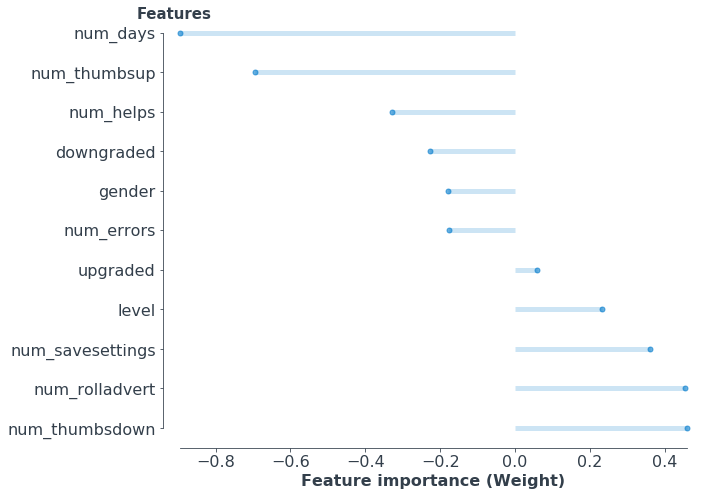

In [106]:
"""
Making bar plots beautiful
I've used the code from https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html
as a basis for this plot.
"""

# set font
plt.rcParams['font.family'] = 'DeJaVu Sans'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(feat_importance.index)+1))

fig, ax = plt.subplots(figsize=(10,8))

# create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=feat_importance['Absolute Weight'], color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(feat_importance['Absolute Weight'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel('Feature importance (Weight)', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=16)
plt.yticks(my_range, feat_importance['Features'])

# add an horizonal label for the y axis 
fig.text(0.1, 0.87, 'Features', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

# set the spines position
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', 0.015))
plt.savefig(r'C:\Users\hnbez\Documents\GitHub\Portfolio_under_construction\Sparkify/feat_importance.png',bbox_inches="tight")